# **Normalized Convolution**

In this notebook we will explore the Normalized Convolution as described in section 3 of this [paper](http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf). Efficent implementation of the approach was inspired by this repository: https://github.com/ericPrince/optical-flow

In [1]:
import scipy
import numpy as np
import cv2
from skimage.data import astronaut
import matplotlib.pyplot as plt
%matplotlib inline

##### Get the test image

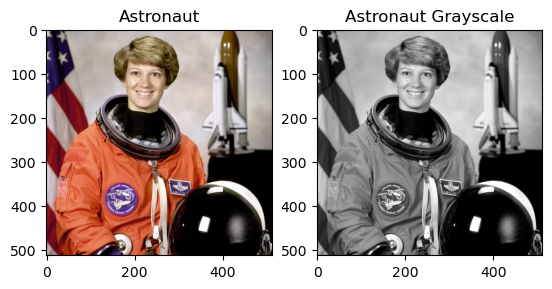

In [2]:
image_rgb = astronaut()
image= cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

plt.subplot(121)
plt.imshow(image_rgb)
plt.title("Astronaut");

plt.subplot(122)
plt.imshow(image, cmap='gray')
plt.title("Astronaut Grayscale");

#### Next we will randomly sample a percentage of pixels in the image to simulate a degraded image. The portion of pixels to randonly sample is denoted by $\alpha$.

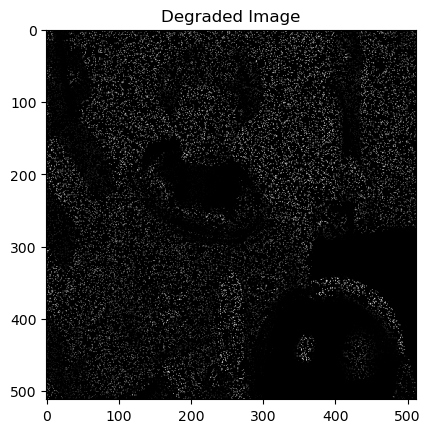

In [3]:
alpha = 0.1 # probability of selecting a pixel
rng = np.random.default_rng()
mask = rng.choice([0,1], size=image.shape, p=[1 - alpha, alpha])

degraded_image = image.copy()
degraded_image[mask == 0] = 0

plt.imshow(degraded_image, cmap='gray')
plt.title("Degraded Image");

### Now let's implement Normalized Convolution to restore this image

First we will see how a regular convolution works for this task

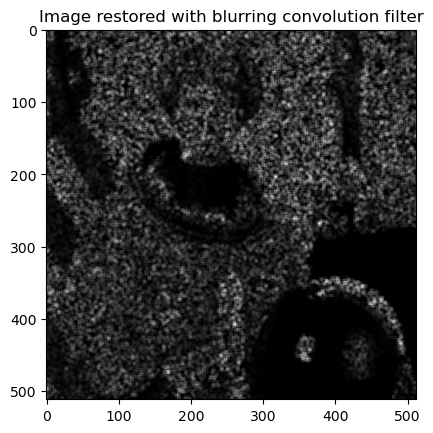

In [4]:
# Apply blurring kernel
kernel = np.ones((5, 5), np.float32) / 25
restore_conv = cv2.filter2D(src=degraded_image, ddepth=-1, kernel=kernel)

plt.imshow(restore_conv, cmap='gray')
plt.title("Image restored with blurring convolution filter");

Using a regular convolution does not work very well. This is because no compensation is made for the variation in local sampling density.


### Now let's implement Normalized Convolution

In [102]:
def normalized_convolution(f: np.ndarray, c: np.ndarray, a: np.ndarray,
                           bx: np.ndarray, by: np.ndarray)-> np.ndarray:
    """ Computes Normalized Convolution and returns the coefficients r as well as 
        The polynomial basis functions in the x and y dimensions. For the efficieny,
        the computations are implemented as separable convolutions. 

        Inputs: 
            f  - signal
            c  - signal certainty (same shape as the signal)
            a  - (nxn) applicability kernel for each pixel
            bx - x-dimension basis functions of predefined polynomial order
            by - y-dimension basis functions of predefined polynomial order

        Outputs
            r - Computed Coefficients --> parameterization for input polynomial basis functions
            
        References:
            [1]    G. Farneback, “Polynomial Expansion for Orientation and Motion Estimation,” 
            Ph.D. dissertation, Inst. of  Technology, Linköping Univ., Norrköping, Sweden, 2002. 
            [Online]. Available: http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf
            (Chapter 3)
        """
    # get dimensionality of applicability
    n = a.shape[0]

    # reshape applicability kernel
    a = a.reshape(-1)

    # Pre-calculate product of certainty and signal
    cf = c * f

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab_x = np.einsum("i,ij->ij", a, bx)
    abb_x = np.einsum("ij,ik->ijk", ab_x, bx)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb_x[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab_x[..., i], axis=0, mode="constant", cval=0
        )

    
    # Pre-calculate quantities recommended in paper
    ab_y = np.einsum("i,ij->ij", a, by)
    abb_y = np.einsum("ij,ik->ijk", ab_y, by)

    # Calculate G and v for each pixel with cross-correlation
    # Note that these are of the form x = x*b or x *= b
    # We have already included the c and cf terms in the x-dim computation
    for i in range(by.shape[-1]):
        for j in range(by.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb_y[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab_y[..., i], axis=1, mode="constant", cval=0
        )

    # if G is singular, then we will need to reduce the singularity 
    # if np.any(~np.isfinite(np.linalg.cond(G))):
    #     # add a small Normal perturbation to reduce singularity of G
    #     G += np.random.normal(loc=0, scale=0.001, size=G.shape)

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    return r

In [103]:
# get applicability
a = np.array([
    [1, 1, 2, 1, 1],
    [1, 2, 4, 2, 1],
    [2, 4, 7, 4, 2],
    [1, 2, 4, 2, 1],
    [1, 1, 2, 1, 1]
])


# get basis x-dim and y-dim functions for: {1, x, y, x2, xy, y2}
n = a.shape[0]
b = np.repeat(np.c_[np.arange(-(n-1)//2, (n+1)//2)], 
                n, axis=-1).T

# x dimension (set y=1)
bx = np.vstack((
    np.ones((n**2)),    # 1
    b.T.reshape(-1),    # x
    np.ones((n**2)),    # y
    b.T.reshape(-1)**2, # x^2
    b.T.reshape(-1),    # xy
    np.ones((n**2)),    # y^2
)).T

# y dimension (set x=1)
by = np.vstack((
    np.ones((n**2)),  # 1
    np.ones((n**2)),  # x
    b.reshape(-1),    # y
    np.ones((n**2)),  # x^2
    b.reshape(-1),    # xy
    b.reshape(-1)**2, # y^2
)).T


r = normalized_convolution(degraded_image, mask, a, bx, by)

In [104]:
    
def get_restored_image(r, bx, by, shape):
    """ Obtains restored image from Normalized Convolution
        Inputs:
            bx - x-dimension basis functions of predefined polynomial order
            by - y-dimension basis functions of predefined polynomial order 
            shape - shape of original image
        """
    fx = np.zeros(r.shape).astype(np.float64)
    fy = np.zeros(r.shape).astype(np.float64)

    for i in range(bx.shape[1]):
        fx[..., i] = scipy.ndimage.correlate1d(
                    r[..., i], np.float64(bx[:, i]), axis=0, mode="constant", cval=0
                )

    # axis = 0 for y axis?
    for i in range(by.shape[1]):
        fy[..., i] = scipy.ndimage.correlate1d(
                    r[..., i], by[:, i], axis=1, mode="constant", cval=0
                )
        
    return fx, fy

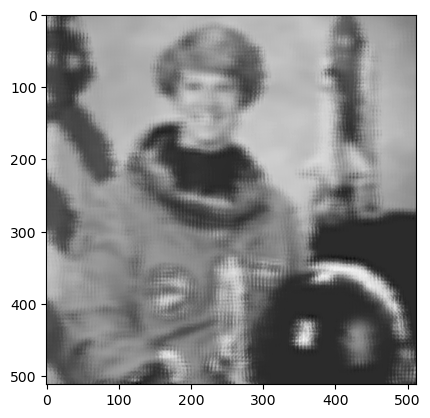

In [114]:
plt.imshow(
    cv2.normalize(r[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U),
    cmap='gray'
)

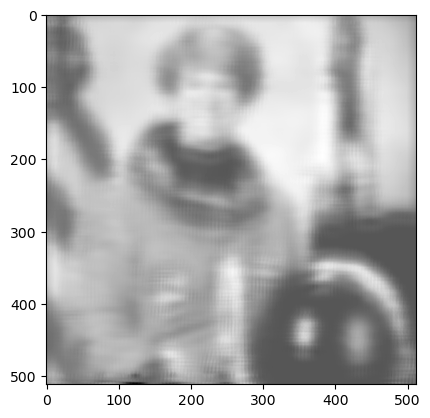

In [121]:
fx, fy = get_restored_image(r, bx, by, image.shape)
result = cv2.normalize(np.sum(fx, axis=-1) + np.sum(fy, axis=-1), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.imshow(result, cmap='gray')

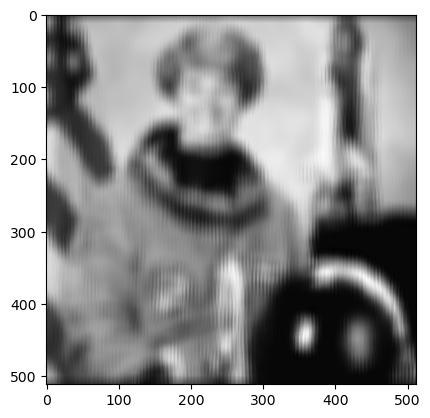

In [108]:
plt.imshow(
    cv2.normalize(fx[:, :, 0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),
    cmap='gray')

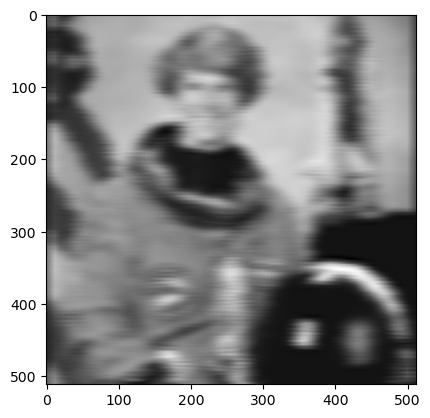

In [109]:
plt.imshow(
    cv2.normalize(fy[:, :, 0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),
    cmap='gray')

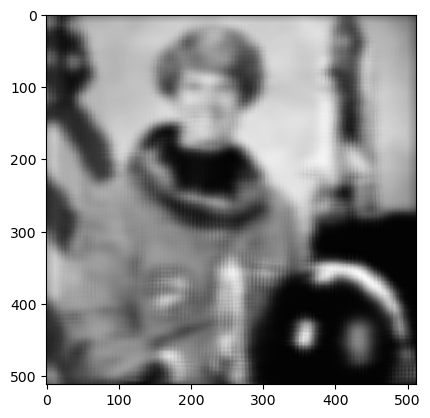

In [122]:
r2 = cv2.addWeighted(
    cv2.normalize(fx[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), 
    0.5, 
    cv2.normalize(fy[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), 
    0.5, 
    0)
plt.imshow(r2, cmap='gray')

Need to find out how to include this gradient information in the reconstructed images

Let's try a different Applicability kernel

In [11]:
afun = np.vectorize(lambda x: 0.5*x**(-3) if ((abs(x) > 1) and (abs(x) < 8)) else 1)


def cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True):
    complex_format = x - x_c + 1j * (y - y_c)
    return np.abs(complex_format), np.angle(complex_format, deg = deg)

In [12]:
n = 7
x, y = np.mgrid[-(n-1)//2:(n+1)//2, -(n-1)//2:(n+1)//2]
rho, theta = cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True)


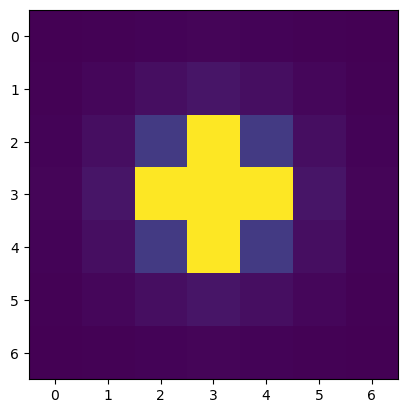

In [13]:
plt.imshow(afun(rho))

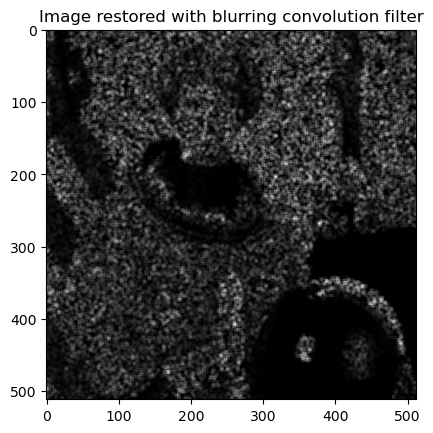

In [72]:

applicability = cv2.normalize(afun(rho)+1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
restored = cv2.filter2D(src=degraded_image, ddepth=-1, kernel=applicability)
restored = cv2.normalize(restored, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.imshow(restore_conv, cmap='gray')
plt.title("Image restored with blurring convolution filter");

##### Take convolution of Applicability Kernel with the certainty field with a DC basis function

In [73]:
# applicability = cv2.normalize(applicability, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
r = normalized_convolution(degraded_image, mask, applicability, 
                           np.ones((n*n, 1)), 
                           np.ones((n*n, 1))
                           )

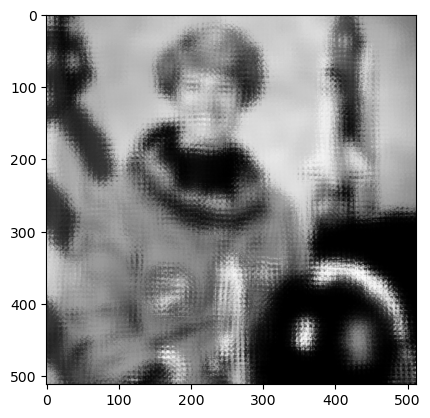

In [74]:
plt.imshow(
    cv2.normalize(r.squeeze(), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),
    cmap='gray')

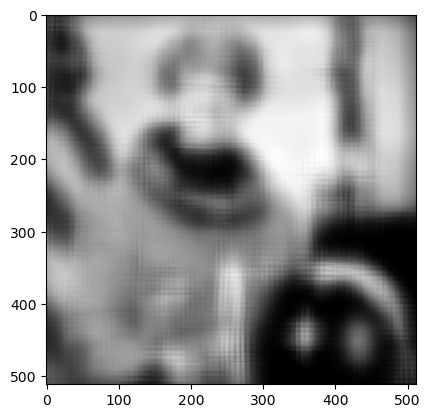

In [21]:
fx, fy = get_restored_image(r, np.ones((n*n, 1)), np.ones((n*n, 1)), image.shape)
result = cv2.normalize(fx + fy, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.imshow(result, cmap='gray')

##### Try this again!

In [123]:
n = 7
b = np.repeat(np.c_[np.arange(-(n-1)//2, (n+1)//2)], 
                7, axis=-1).T

# x dimension (set y=1)
bx = np.vstack((
    np.ones((n**2)),    # 1
    b.T.reshape(-1),    # x
    np.ones((n**2)),    # y
    b.T.reshape(-1)**2, # x^2
    b.T.reshape(-1),    # xy
    np.ones((n**2)),    # y^2
)).T

# y dimension (set x=1)
by = np.vstack((
    np.ones((n**2)),  # 1
    np.ones((n**2)),  # x
    b.reshape(-1),    # y
    np.ones((n**2)),  # x^2
    b.reshape(-1),    # xy
    b.reshape(-1)**2, # y^2
)).T

In [124]:
x, y = np.mgrid[-(n-1)//2:(n+1)//2, -(n-1)//2:(n+1)//2]
rho, theta = cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True)
applicability = cv2.normalize(afun(rho)+1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


In [125]:
r = normalized_convolution(degraded_image, mask, applicability, 
                           bx, 
                           by
                           )

In [126]:
np.mean(r, axis=-1).shape

(512, 512)

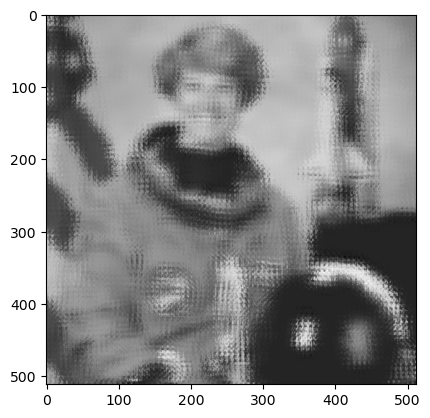

In [131]:
plt.imshow(
    cv2.normalize(r[:, :, 0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),
    cmap='gray')

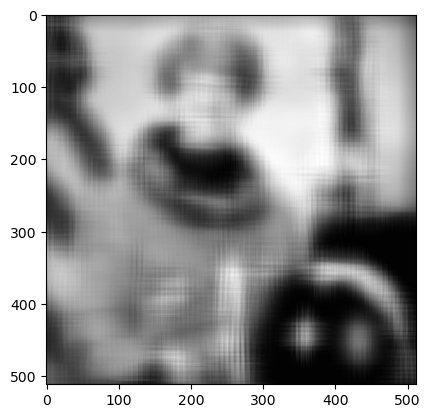

In [128]:
fx, fy = get_restored_image(r, bx, by, image.shape)

r2 = cv2.addWeighted(
    cv2.normalize(fx[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), 
    0.5, 
    cv2.normalize(fy[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), 
    0.5, 
    0)
plt.imshow(r2, cmap='gray')

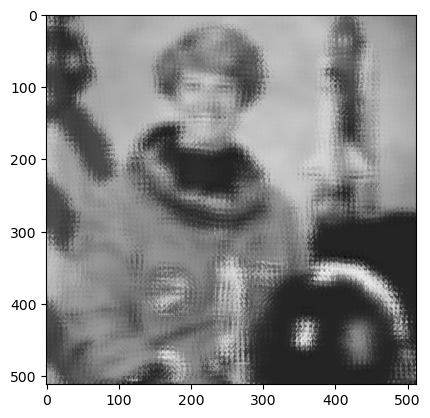

In [130]:
plt.imshow(r[:, :, 0], cmap='gray')

In [99]:
np.mean(r[:, :, 2])

-0.04777951617089941

##### Now take the original output from the convolutional filter and divide by the

In [23]:
tmp = cv2.normalize(r.squeeze(), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [25]:
tmp2 = restored/tmp

C:\Users\itber\AppData\Local\Temp\ipykernel_24616\4178899036.py:1: RuntimeWarning: invalid value encountered in divide
  tmp2 = restored/tmp


In [48]:
tmp2[np.isnan(tmp2)] = 1
tmp3 = cv2.normalize(np.clip(tmp2, 0, 10), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

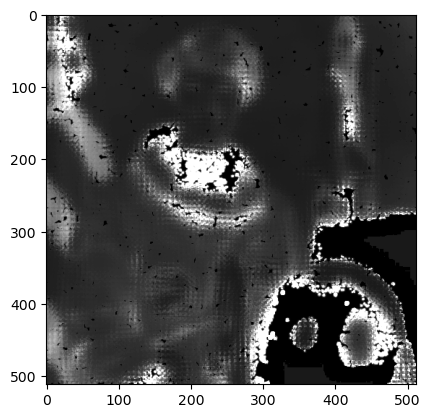

In [49]:
plt.imshow(tmp3, cmap='gray')

In [38]:
tmp2.max()

493.37842

C:\Users\itber\AppData\Local\Temp\ipykernel_24616\2168059291.py:1: RuntimeWarning: invalid value encountered in divide
  result_2 = restored/result


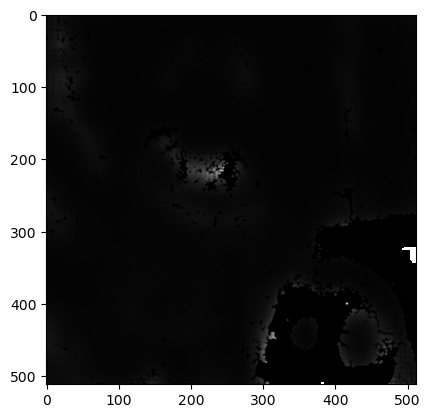

In [22]:
result_2 = restored/result
# np.clip(result_2, 0, 2)
result_2 = cv2.normalize(result_2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(result_2, cmap='gray')

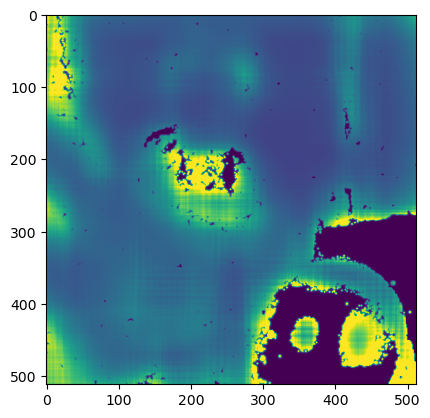

In [219]:
plt.imshow(np.clip(result_2, 0, 5))

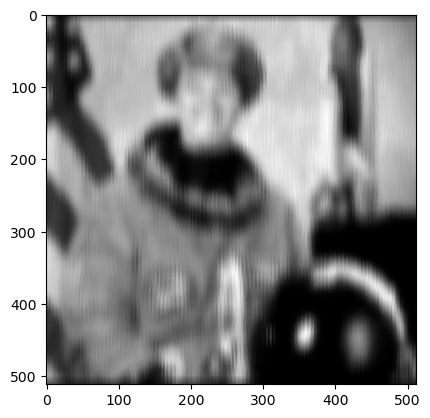

In [118]:
result = cv2.normalize(fx + fy, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(result, cmap='gray')

In [119]:
np.min(restore.squeeze()/result)

C:\Users\itber\AppData\Local\Temp\ipykernel_7024\834554728.py:1: RuntimeWarning: invalid value encountered in divide
  np.min(restore.squeeze()/result)


nan

In [74]:
np.max(r.squeeze()/result)

C:\Users\itber\AppData\Local\Temp\ipykernel_7024\2171022479.py:1: RuntimeWarning: invalid value encountered in divide
  np.max(r.squeeze()/result)


nan

In [77]:
tmp.max()

2819.5077032529066

C:\Users\itber\AppData\Local\Temp\ipykernel_7024\486868372.py:1: RuntimeWarning: invalid value encountered in divide
  tmp = restore.squeeze()/result


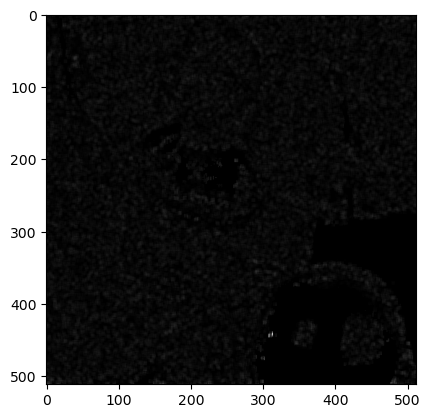

In [121]:
tmp = restore.squeeze()/result
tmp[np.isnan(tmp)] = 0

result2 = cv2.normalize(tmp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.imshow(result2*100, cmap='gray')

In [82]:
result2

array([[0.1603844 , 0.16010731, 0.15662204, ..., 0.1626159 , 0.16295606,
        0.16277309],
       [0.13856173, 0.1402281 , 0.14009997, ..., 0.15240918, 0.15129706,
        0.15103935],
       [0.13130653, 0.13508974, 0.13408017, ..., 0.14321691, 0.14241652,
        0.14147423],
       ...,
       [0.13629459, 0.14118475, 0.1402069 , ..., 0.01978061, 0.01272211,
        0.02336401],
       [0.14522277, 0.14909558, 0.14222492, ..., 0.05759913, 0.04018597,
        0.04972452],
       [0.1562315 , 0.15990284, 0.15250888, ..., 0.12882511, 0.05635045,
        0.0675205 ]], dtype=float32)

$ r = (B^* W_a W_c B)^{-1} B^* W_a W_c f $

### Reconstruct the signal with
$ \hat{f} = Br $

 [1]    G. Farneback, “Polynomial Expansion for Orientation and Motion Estimation,” Ph.D. dissertation, Inst. of Technology, Linköping Univ., Norrköping, Sweden, 2002. [Online]. Available: http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf